## Data preparation

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(gridExtra)

In [3]:
plot_distribution <- function(dataframe, var_name, title, n_bins) {
  plot <- ggplot(dataframe, aes(x = get(var_name))) + 
  geom_histogram(aes(y = after_stat(density)), bins = n_bins, colour="black") + 
  labs(x = title) +
  geom_density(colour="red", linewidth = 1.3) + 
  theme(axis.text = element_text(size = 16),
  axis.title.y = element_blank(), 
  axis.title.x = element_text(size = 20))
  return(plot)
}
min_max_scaling <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}

In [7]:
setwd("/Users/wilson/Desktop/Projects/Heart failure - Survival analysis")

In [8]:
df0 <- read.csv("./data/S1Data.csv")
df0 <- df0 %>%
  rename_with(tolower) %>% 
  rename(platelets = pletelets) %>%
  mutate_at(vars(gender, smoking, diabetes, bp, anaemia), factor)

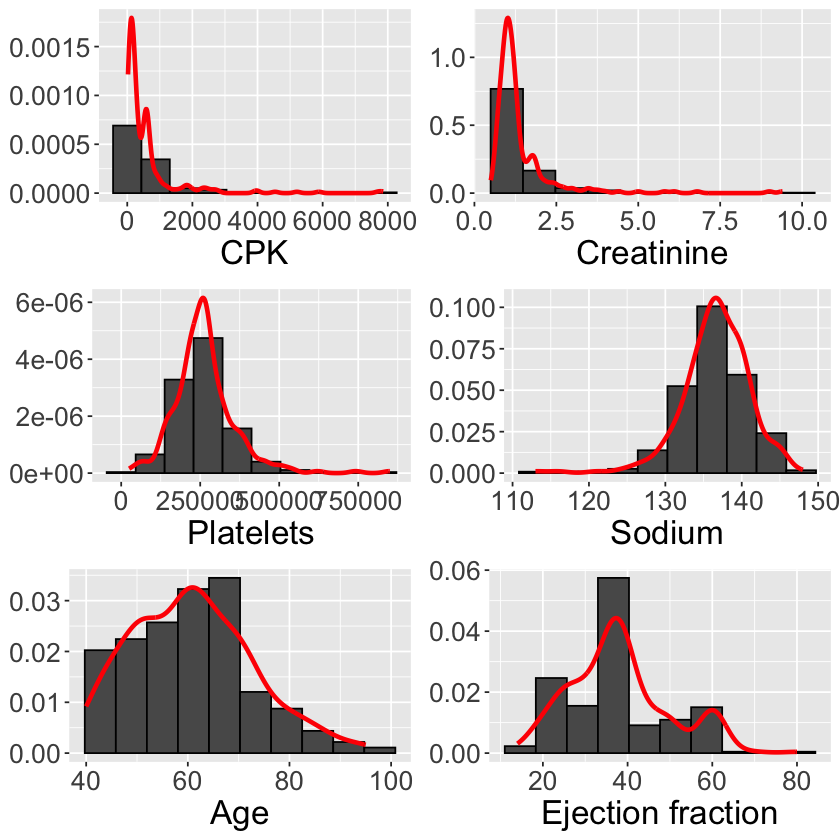

In [9]:
plot_cpk <- plot_distribution(df0, "cpk", "CPK", 10)
plot_creatinine <- plot_distribution(df0, "creatinine", "Creatinine", 10)
plot_platelets <- plot_distribution(df0, "platelets", "Platelets", 10)
plot_sodium <- plot_distribution(df0, "sodium", "Sodium", 10)
plot_age <- plot_distribution(df0, "age", "Age", 10)
plot_ef <- plot_distribution(df0, "ejection.fraction", "Ejection fraction", 10)
ggplot_list <- list(plot_cpk, plot_creatinine, plot_platelets, plot_sodium, plot_age, plot_ef)
grid.arrange(grobs = ggplot_list, ncol = 2)

* `CPK` and `creatinine` are heavily skewed, so log transformation may be needed
* The distribution of `platelets` and `sodium` look like a bell curve. To rescale these variable, z-score scaling may be required 
* Min-Max scaling can be performed for `age` and `ejection.fraction` because there are no signifcant outliers

### Log transformation - `CPK` and `creatinine`

In [10]:
df0 <- df0 %>% 
  mutate(log_cpk = log(cpk), log_creatinine = log(creatinine))

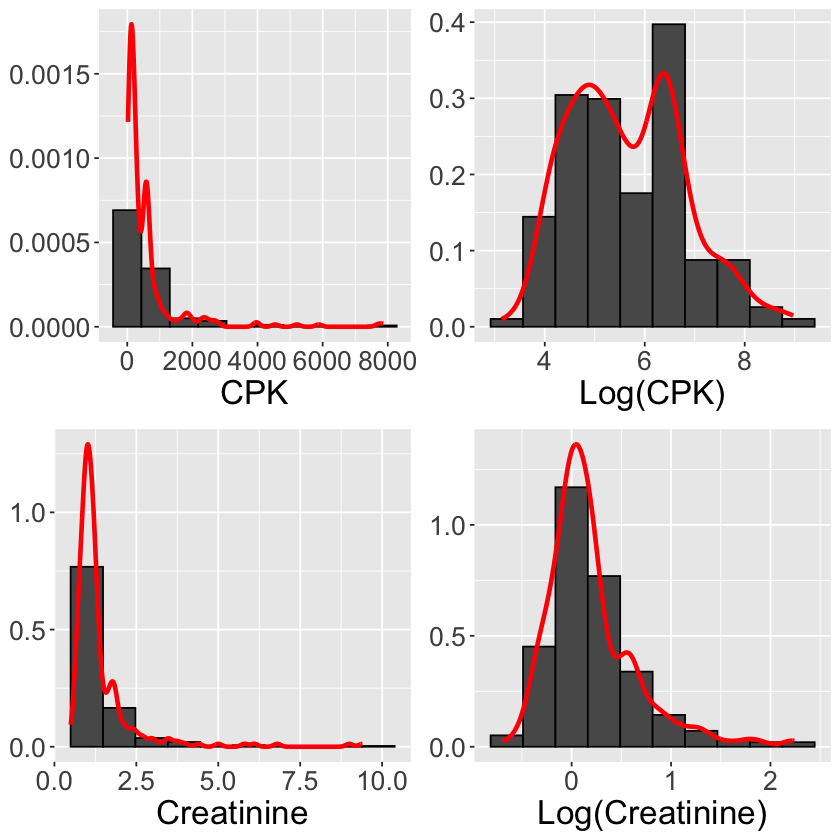

In [11]:
plot_log_creatinine <- plot_distribution(df0, "log_creatinine", "Log(Creatinine)", 10)
plot_log_cpk <- plot_distribution(df0, "log_cpk", "Log(CPK)", 10)
grid.arrange(plot_cpk, plot_log_cpk, plot_creatinine, plot_log_creatinine, ncol = 2)

### Standardisation - `platelets` & `sodium`

In [12]:
df0 <- df0 %>%
  mutate(standardised_platelets = scale(platelets)[,1]) %>%
  mutate(standardised_sodium = scale(sodium)[,1])

In [13]:
# Save the mean and standard deviation of platelets and sodium
standardised_data <- scale(df0["platelets"])
mean_platelets <- attr(standardised_data, "scaled:center")
sd_platelets <- attr(standardised_data, "scaled:scale")
standardised_data <- scale(df0["sodium"])
mean_sodium <- attr(standardised_data, "scaled:center")
sd_sodium <- attr(standardised_data, "scaled:scale")

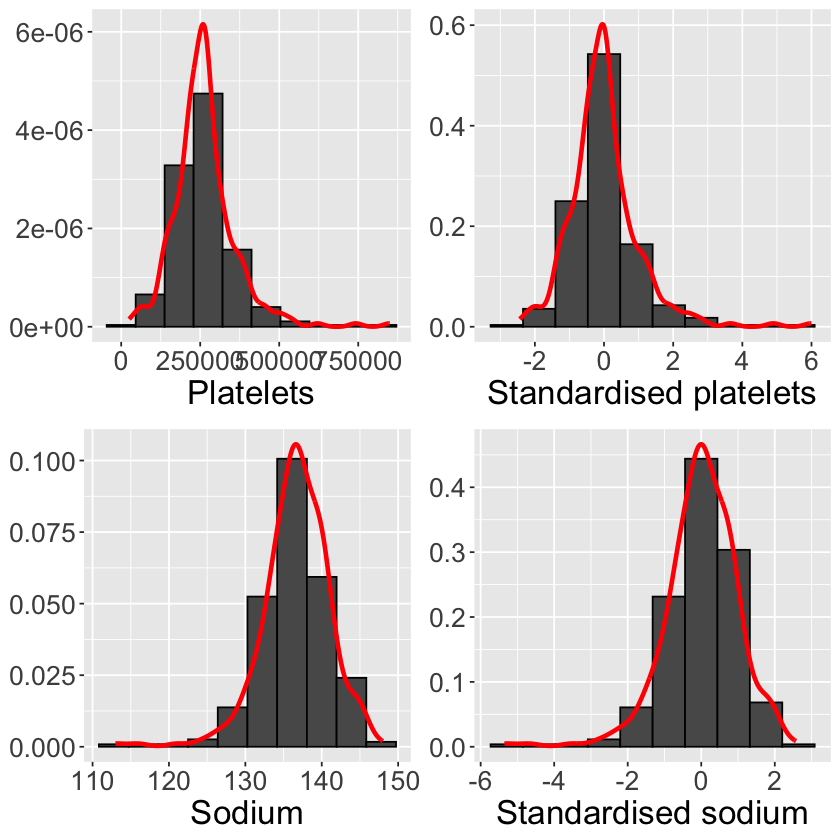

In [14]:
plot_standardised_platelets <- plot_distribution(df0, "standardised_platelets", "Standardised platelets", 10)
plot_standardised_sodium <- plot_distribution(df0, "standardised_sodium", "Standardised sodium", 10)
grid.arrange(plot_platelets, plot_standardised_platelets, plot_sodium, plot_standardised_sodium, ncol = 2)

### Normalisation - `age` & `EF`

In [15]:
df0 <- df0 %>% 
  mutate(normalised_age = min_max_scaling(age)) %>%
  mutate(normalised_ejection.fraction = min_max_scaling(ejection.fraction))

In [16]:
min_age <- min(df0["age"])
max_age <- max(df0["age"])
min_ef <- min(df0["ejection.fraction"])
max_ef <- max(df0["ejection.fraction"])
cat("Minimum Age:", min_age, "\n")
cat("Maximum Age:", max_age, "\n")
cat("Minimum Ejection Fraction:", min_ef, "\n")
cat("Maximum Ejection Fraction:", max_ef, "\n")

Minimum Age: 40 
Maximum Age: 95 
Minimum Ejection Fraction: 14 
Maximum Ejection Fraction: 80 


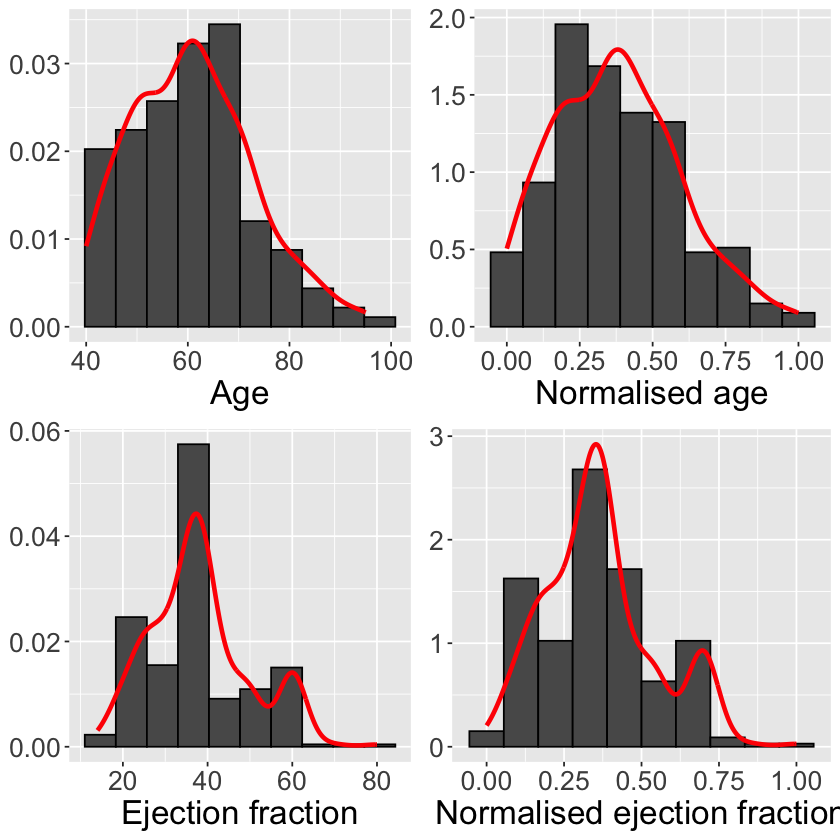

In [17]:
plot_normalised_age <- plot_distribution(df0, "normalised_age", "Normalised age", 10)
plot_normalised_ef <- plot_distribution(df0, "normalised_ejection.fraction", "Normalised ejection fraction", 10)
grid.arrange(plot_age, plot_normalised_age, plot_ef, plot_normalised_ef, ncol = 2)

### Categorisation
The following variables were categorized based on clinical guidelines and statistical considerations
* `age_gp`: suggested by Tromp et al. (2021)
    * `<55 years`
    * `55-64 years`
    * `65-74 years`
    * `>=75 years`
* `ef_gp`: 
    * `<40%`: Heart failure with reduced ejection fraction (HFrEF)
    * `40-49%`: Borderline EF
    * `50-74%`: Normal EF range
    * `>=75%`: Potentially hypertrophic cardiomyopathy
* `ef_paper`: suggested by Ahmad et al. (2017)
    * `<=30%`: Severe systolic dysfunction
    * `31-45%`: Moderate systolic dysfunction
    * `>45%`: Mild or no systolic dysfunction
* `sodium`: 
    * `<135mmol/L`: Hyponatremia (associated with increased morbidity)
    * `135-145mmol/L`: Normal range
    * `>145mmol/L`: Hypernatremia (rare in heart disease patients)
* `creatinine_excess`: 
    * `0` for normal levels (≤1.04 mg/dL for women, ≤1.35 mg/dL for men)
    * `1` for elevated levels (>1.04 mg/dL for women, >1.35 mg/dL for men)
* `creatinine_paper`: suggested by Ahmad et al. (2017)
    * `0` for normal levels (≤1.5 mg/dL)
    * `1` for elevated levels (>1.5 mg/dL)
* `platelets_gp`: 
    * `Thrombocytopenia`: <150,000/μL (increased bleeding risk)
    * `Normal`: 150,000-450,000/μL (healthy range)
    * `Thrombocytosis`: >450,000/μL (potential clotting risk)
* `platelets_paper`: suggested by Ahmad et al. (2017)
    * `<=Q1`: Below first quartile
    * `Q1-Q3`: Interquartile range
    * `>=Q3`: Above third quartile
* `cpk_excess`: 
    * `0`: Normal levels (≤120 mcg/L)
    * `1`: Elevated levels (>120 mcg/L, indicating potential muscle or heart damage)

In [18]:
breaks_age <- c(-Inf, 55, 65, 75, Inf) # right closed: FALSE
labels_age <- c("<55 years", "55-64 years", "65-74 years", ">=75 years")

breaks_ef <- c(-Inf, 40, 50, 75, Inf) # right closed: FALSE
labels_ef <- c("<40%", "40-49%", "50-74%", ">=75%")

breaks_ef_paper <- c(-Inf, 30, 45, Inf) # right closed: TRUE
labels_ef_paper <- c("<=30%", "31-45%", ">45%")

breaks_sodium <- c(-Inf, 135, 146, Inf) # right closed: FALSE
labels_sodium <-c("<135mmol/L", "135-145mmol/L", ">145mmol/L")

breaks_platelets <- c(-Inf, 150000, 450000+1, Inf) # right closed: FALSE
labels_platelets <- c("Thrombocytopenia", "Normal", "Thrombocytosis")

breaks_platelets_paper <- c(-Inf, quantile(df0$platelets,0.25), quantile(df0$platelets,0.75)-1, Inf) # right closed: TRUE
labels_platelets_paper <- c("<=Q1", "Q1-Q3", ">=Q3")

In [19]:
df0 <- df0 %>%
  mutate(
    age_gp = cut(age, breaks = breaks_age, labels = labels_age, right = FALSE),
    ef_gp = cut(ejection.fraction, breaks = breaks_ef, labels = labels_ef, right = FALSE),
    ef_gp = relevel(ef_gp, ref = "50-74%"),
    ef_paper = cut(ejection.fraction, breaks = breaks_ef_paper, labels = labels_ef_paper, right = TRUE),
    sodium_gp = cut(sodium, breaks = breaks_sodium, labels = labels_sodium, right = FALSE), 
    sodium_gp = relevel(sodium_gp, ref = "135-145mmol/L"),
    creatinine_excess = ifelse((gender == 0 & creatinine > 1.04) | (gender == 1 & creatinine > 1.35), 1, 0),
    creatinine_paper = ifelse(creatinine > 1.5, 1, 0),
    platelets_gp = cut(platelets, breaks = breaks_platelets, labels = labels_platelets, right = FALSE),
    platelets_gp = relevel(platelets_gp, ref = "Normal"),
    platelets_paper = cut(platelets, breaks = breaks_platelets_paper, labels = labels_platelets_paper, right = TRUE), 
    platelets_paper = relevel(platelets_paper, ref = "Q1-Q3"),
    cpk_excess = ifelse(cpk > 120, 1, 0),
    across(c(creatinine_excess, creatinine_paper, cpk_excess), ~ factor(.))
    )
# mutate_at(vars(creatinine_excess, creatinine_paper, cpk_excess), factor)

In [20]:
variables <- c("age_gp", "ef_gp", "ef_paper", "sodium_gp", "creatinine_excess", "creatinine_paper", "platelets_gp", "platelets_paper", "cpk_excess")
summary(df0[, which(names(df0) %in% variables)])

         age_gp      ef_gp       ef_paper           sodium_gp  
 <55 years  :95   50-74%: 59   <=30% : 93   135-145mmol/L:214  
 55-64 years:89   <40%  :182   31-45%:146   <135mmol/L   : 83  
 65-74 years:74   40-49%: 57   >45%  : 60   >145mmol/L   :  2  
 >=75 years :41   >=75% :  1                                   
 creatinine_excess creatinine_paper           platelets_gp platelets_paper
 0:193             0:232            Normal          :259   Q1-Q3:149      
 1:106             1: 67            Thrombocytopenia: 27   <=Q1 : 75      
                                    Thrombocytosis  : 13   >=Q3 : 75      
                                                                          
 cpk_excess
 0: 77     
 1:222     
           
           

### Clipping

In [21]:
# df1 <- df0 %>%
#     filter(ef_gp != ">=75%", sodium_gp != ">145mmol/L") %>%
#     mutate(
#         sodium_gp = factor(sodium_gp, levels = levels(sodium_gp)[levels(sodium_gp) %in% sodium_gp]),
#         ef_gp = factor(ef_gp, levels = levels(ef_gp)[levels(ef_gp) %in% ef_gp]))
df1 <- df0 %>%
    filter(ef_gp != ">=75%") %>%
    mutate(
        ef_gp = factor(ef_gp, levels = levels(ef_gp)[levels(ef_gp) %in% ef_gp]))

In [22]:
cat("Number of rows:", nrow(df1), "\n")
cat("Number of columns:", ncol(df1))

Number of rows: 298 
Number of columns: 28

### Output dataset

In [ ]:
# write.csv(df0, "./data/df0.csv", row.names=FALSE)
# write.csv(df1, "./data/df1.csv", row.names=FALSE)

### Reference

* Ahmad, T., Munir, A., Bhatti, S.H., Aftab, M. and Raza, M.A., 2017. _Survival analysis of heart failure patients: A case study._ PLoS ONE, 12(7), p.e0181001. https://doi.org/10.1371/journal.pone.0181001
* Tromp, J., Paniagua, S.M.A., Lau, E.S., Allen, N.B., Blaha, M.J., Gansevoort, R.T., Hillege, H.L., Lee, D.E., Levy, D., Vasan, R.S., van der Harst, P., van Gilst, W.H., Larson, M.G., Shah, S.J., de Boer, R.A., Lam, C.S.P., Ho, J.E. and Shah, S.J., 2021. _Age dependent associations of risk factors with heart failure: pooled population based cohort study._ BMJ, 372, n461. https://doi.org/10.1136/bmj.n461